In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest,f_regression
import catboost as catb
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv(r'C:\Users\okruz\Downloads\kaggle\heart_disease_health_indicators_BRFSS2015.csv')
pd.set_option('display.max_columns', 100)

In [2]:
df.iloc[:, 0].value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

In [3]:
TARGET_NAME = 'HeartDiseaseorAttack'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
df = balance_df_by_target(df, TARGET_NAME)

In [6]:
df.iloc[:, 0].value_counts()

0.0    229787
1.0    215037
Name: HeartDiseaseorAttack, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444824 entries, 202286 to 242045
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  444824 non-null  float64
 1   HighBP                444824 non-null  float64
 2   HighChol              444824 non-null  float64
 3   CholCheck             444824 non-null  float64
 4   BMI                   444824 non-null  float64
 5   Smoker                444824 non-null  float64
 6   Stroke                444824 non-null  float64
 7   Diabetes              444824 non-null  float64
 8   PhysActivity          444824 non-null  float64
 9   Fruits                444824 non-null  float64
 10  Veggies               444824 non-null  float64
 11  HvyAlcoholConsump     444824 non-null  float64
 12  AnyHealthcare         444824 non-null  float64
 13  NoDocbcCost           444824 non-null  float64
 14  GenHlth               444824 non-null  float64


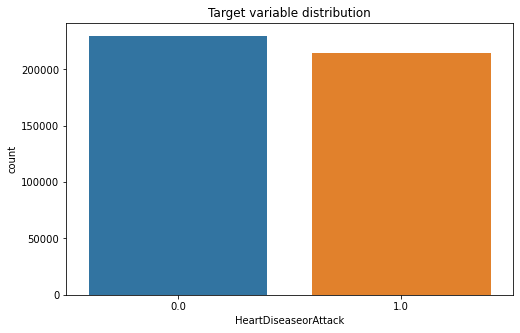

In [8]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

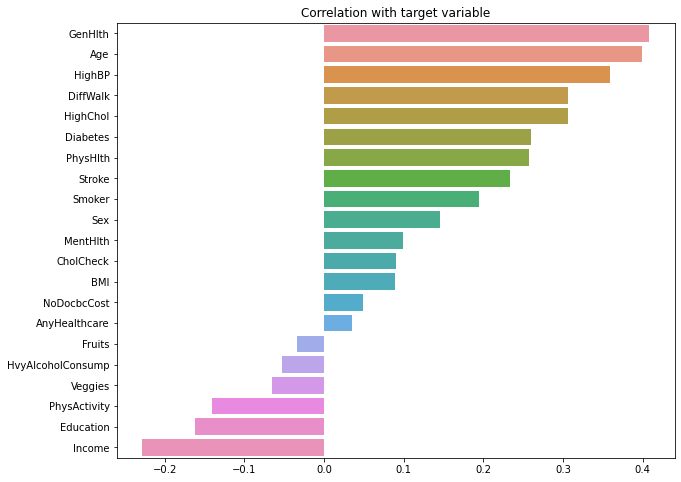

In [9]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

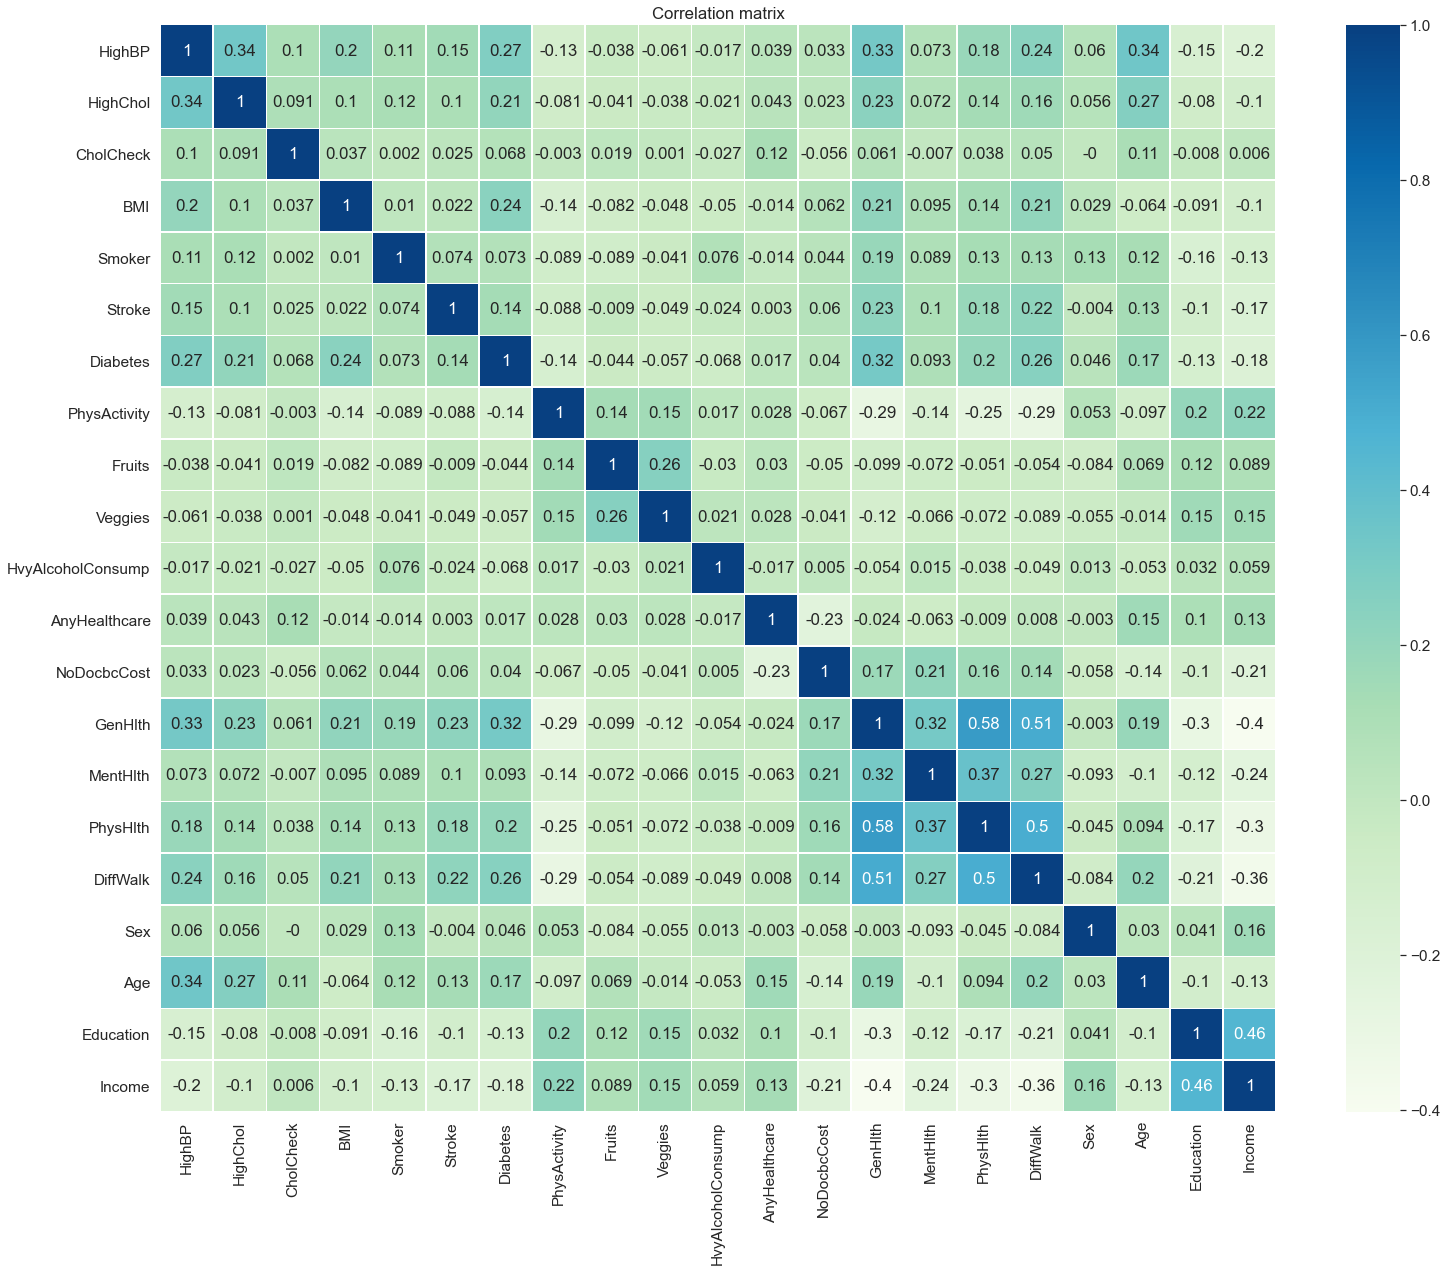

In [10]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [11]:
X = df[BASE_FEATURE_NAMES]

In [12]:
continuous_columns = ["BMI", "GenHlth", 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

scaler = StandardScaler()
stand_features = scaler.fit_transform(X[continuous_columns])

In [13]:
X[continuous_columns] = pd.DataFrame(stand_features, columns=continuous_columns)
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
202286,0.0,1.0,1.0,-0.127152,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.104614,-0.462834,-0.605610,0.0,1.0,1.391724,-0.894125,0.152780
337008,1.0,1.0,1.0,-0.575548,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.760504,1.958237,0.827366,0.0,0.0,-1.350345,-0.894125,1.072666
125894,1.0,1.0,1.0,0.022313,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,-1.625622,-0.462834,-0.605610,0.0,0.0,-1.007587,0.077079,-0.767106
260267,1.0,0.0,1.0,0.620174,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.104614,-0.462834,0.063112,1.0,1.0,1.048965,-0.894125,-0.767106
206670,1.0,0.0,1.0,-0.575548,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.969732,-0.462834,-0.319015,0.0,0.0,0.706206,1.048282,1.072666


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, df[TARGET_NAME], random_state=42)

In [15]:
import xgboost
import shap

In [16]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

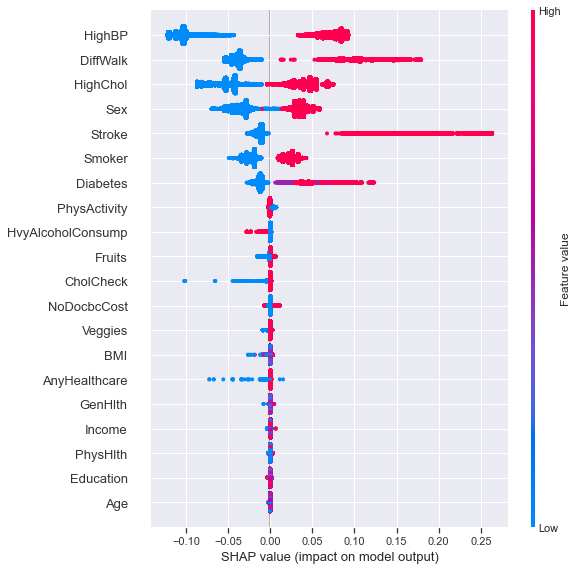

In [17]:
shap.summary_plot(shap_values, X_train)

1) Вероятность ишемической болезни сердца (ИБС) или инфаркта миокарда (ИМ) больше, если у человека диабет или если у человека когда-либо был инсульт
2) Вероятность выше, если человек испытывал трудности при ходьбе или подъеме по лестнице
3) Вероятность инфартка выше, если у человека диабет
4) У людей с медицинской страховкой меньше случаев инфаркта
5) Странная статистика по инфарктам у людей потребляющих алкоголь - больше случаев у тех, кто не употребляет много алкоголя